# Parte 2 1ª Practica: implementación DQN LunarLander

Este trabajo ha sido realizado por Adrián Contreras Castillo y Jaime González Delgado. Donde se busca implementar un modelo DQN para jugar al juego LunarLander, donde se busca aterrizar una nave en la superficie. Para ello se cuentan con 8 variables que sirven como input para la red. Mientras que los posibles movimientos que puede realizar la nave son 4, no hacer nada, encender motor izquierdo, encender motor principal o encender motor derecho.

El entrenamiento se ha realizado en la plataforma de Google Colab haciendo uso de las GPUs T4, pero una vez que se ha entrenado se puede cargar el modelo y ejecutarla en un ordenador sin GPU o sin la opción CUDA.

In [1]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376168 sha256=4783866d7ce9d3d3cd9a6e4fc4323e92bda228bfe7cd912f52da902aef56b981
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [1]:
import gymnasium as gym
from gym.wrappers.record_video import RecordVideo
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import math
import time
import glob
from collections import deque

In [2]:
import os
# celda necesaria para que el kernel no muera cuando se ejecuta en local
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
env = gym.make("LunarLander-v2")
num_features = env.observation_space.shape[0]
num_actions = env.action_space.n
print(num_features, num_actions)

8 4


In [4]:
# si esta disponible hacer uso de la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# modelo de la red neuronal
class DQN(nn.Module):
    def __init__(self, num_features, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# creacion de las dos redes neuronales que se van a emplear para aproximar la funcion Q
# main: estima los valores de Q en el presente estado y accion
# target: estima los valores de Q en el siguiente estado y accion
    
main_dqn = DQN(num_features, num_actions).to(device)
target_dqn = DQN(num_features, num_actions).to(device)

optimizer = torch.optim.Adam(main_dqn.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [6]:
# acumular la experiencia para usarla en el entrenamiento
class ReplayBuffer(object):
    def __init__(self, size, device):
        self.buffer = deque(maxlen=size)
        self.device = device

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)

    def sample(self, num_samples):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idx = np.random.choice(len(self.buffer), num_samples)
        for i in idx:
            elem = self.buffer[i]
            state, action, reward, next_state, done = elem
            states.append(np.array(state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        states = torch.as_tensor(np.array(states), device=self.device)
        actions = torch.as_tensor(np.array(actions), device=self.device)
        rewards = torch.as_tensor(
            np.array(rewards, dtype=np.float32), device=self.device
        )
        next_states = torch.as_tensor(np.array(next_states), device=self.device)
        dones = torch.as_tensor(np.array(dones, dtype=np.float32), device=self.device)
        return states, actions, rewards, next_states, dones


In [7]:
# elige una accion con probabilidad epsilon en caso contrario elige la mejor accion segun la red neuronal
def select_epsilon_greedy_action(state, epsilon):
    result = np.random.uniform()
    if result < epsilon:
        return env.action_space.sample()
    else:
        qs = main_dqn(state).cpu().data.numpy()
        return np.argmax(qs)

In [8]:
# entrenamiento de la red en cada interacción
def train_step(states, actions, rewards, next_states, dones):
    max_next_qs = target_dqn(next_states).max(-1).values
    target = rewards + (1.0 - dones) * discount * max_next_qs
    q_values = main_dqn(states)
    action_maasks = F.one_hot(actions, num_actions)
    masked_qs = (action_maasks*q_values).sum(-1)
    loss = loss_fn(masked_qs, target.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_graph(score, mean):
    # n_elem = len(score)//10
    # smothed_score = np.convolve(score, np.ones(n_elem)/n_elem, mode="valid")
    # plt.plot(smothed_score, label="Moving Average score")
    plt.plot(score, label="Score per episode")
    plt.plot(mean, label="Last 100 mean score")
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

In [10]:
# Hyperparameters.
num_episodes = 5000
epsilon = 1.0
batch_size = 128
discount = 0.99
buffer = ReplayBuffer(100000, device=device)
cur_frame = 0
eps_end = 0.1
eps_decay = 0.995

Episode 5000 - Reward: 296.85420695167204 - Epsilon: 0.1 - Avg. Reward: 205.94202897507643


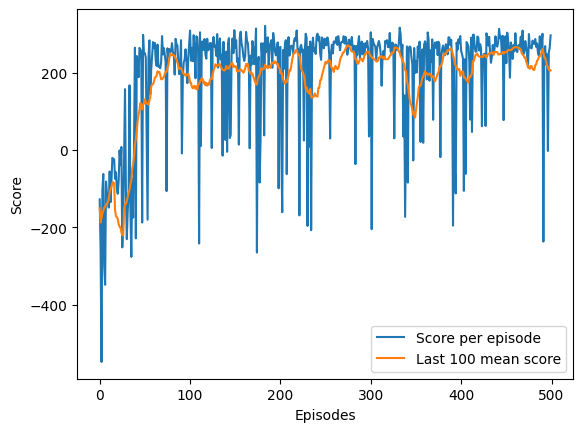

In [11]:
last_100_rewards = []
scores_lst = []
mean_lst = []
for episode in range(num_episodes+1):
    state = env.reset()[0]
    ep_reward, done = 0, False
    while not done:
        state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
        action = select_epsilon_greedy_action(state_in, epsilon)
        next_state, reward, done, info, _ = env.step(action)
        ep_reward += reward
        # salva la experiencia en el buffer
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        cur_frame += 1

        #copiar pesos de la red principal a la red target cada 2000 frames
        if cur_frame%2000 == 0:
            target_dqn.load_state_dict(main_dqn.state_dict())

        # entrenar la red
        if len(buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            loss = train_step(states, actions, rewards, next_states, dones)


    epsilon = max(eps_end, epsilon*eps_decay)

    if len(last_100_rewards) == 100:
        last_100_rewards = last_100_rewards[1:]

    last_100_rewards.append(ep_reward)

    # imprimir el progreso
    if episode % 10 == 0 and episode > 0:
        scores_lst.append(ep_reward)
        mean_lst.append(np.mean(last_100_rewards))
        clear_output()
        print(f"Episode {episode} - Reward: {ep_reward} - Epsilon: {epsilon} - Avg. Reward: {np.mean(last_100_rewards)}")
        plot_graph(scores_lst, mean_lst)



env.close()


In [12]:
# guardar el modelo
torch.save(main_dqn.state_dict(), 'main_dqn.pth')
torch.save(target_dqn.state_dict(), 'target_dqn.pth')
print("Model saved!")


Model saved!


In [13]:
# cargar los modelos cuando esta disponible la GPU
# main_dqn = torch.load('main_dqn.pth')
# target_dqn = torch.load('target_dqn.pth')


# cargar los modelos cuando no esta disponible la GPU
main_dqn.load_state_dict(torch.load('main_dqn.pth', map_location=torch.device('cpu')))
target_dqn.load_state_dict(torch.load('main_dqn.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
main_dqn.eval()

DQN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [15]:
target_dqn.eval()

DQN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [19]:
# comporbar el funcionamiento del modelo entrenado con 10 intentos
# si la puntuación es superior a 200 se considera que la nave consigue aterrizar
env = gym.make("LunarLander-v2", render_mode="human")
for i in range(10):
    state = env.reset()[0]
    done = False
    ep_reward = 0
    while not done:
        env.render()
        state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
        action = select_epsilon_greedy_action(state_in, 0.01)
        next_state, reward, done, info, _ = env.step(action)
        ep_reward += reward
        state = next_state

    print(f"Reward try {i+1}: {ep_reward}")
env.close()

Reward try 1: 255.0638956991729
Reward try 2: 261.5584830669615
Reward try 3: 280.53343222956335
Reward try 4: 226.97638113539224
Reward try 5: 273.6818586790889
Reward try 6: 279.4318226207603
Reward try 7: 283.5450717395825
Reward try 8: 284.6971198134223
Reward try 9: 283.79955257269535
Reward try 10: 224.32750769758468
